# Elastica paper figures
In this notebook the figures from the paper [Keemink & van Rossum (2015) - etc.) are reproduced, and in the process it is shown how to use the elastica library and some general widgets. 

Necessary libraries:
- matplotlib
- scipy
- numpy
- HoloViews (http://holoviews.org/)

In [1]:
import holoviews as hv
%load_ext holoviews.ipython
%output widgets='embed' holomap='widgets' size=150 fig='png'
import elastica_neurons as en
import pylab    as pl
from   pylab import exp,cos,sin,pi,tan

/home/swk/.virtualenvs/main/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


First, let's set the basic model parameters

In [2]:
Ac = 1     # basic tuning magnitude
Kc = 1   # basic tuning width (lower is wider)
a  = 0.1  # modulation strength
E0 = 4     # modulation offset
N  = 128    # number of neurons per location

Define basic plotting functions

In [3]:
def plotsceneandresponses(scene,iLoc):
    ''' plots the scene and the responses plus underlying drive and modulations for location iLoc
    Inputs
    -----------------
    - scene: the scene to plot
    - iLoc: bar position to plot responses and drives+modulations for
    
    Output
    ------------------
    - Holoviews object of the Figure
    '''
    # get the scene plot
    ScenePlot = scene.plotscene()

    # simulate the scene for location iLoc (i.e. the bar number), and assuming we're not on a torus
    scene.simulate(iLoc,torus='off')

    # get the preferred orientations
    pref        = scene.ang/pi

    # get the drive, modulation, and final response of iLoc
    centerdrive = hv.Curve(zip(pref,scene.FRc[iLoc,:]),label='center drive')
    surroundmod = hv.Curve(zip(pref,scene.FRs[iLoc,:]),label='flanker modulation')
    response    = hv.Curve(zip(pref,scene.FR[iLoc,:]),label='response')

    # make the response plot
    ResponsePlot = surroundmod*centerdrive*response

    # get the modulation contributions
    ModContributions = scene.plotlocalmod(iLoc,torus='off')

    # plot 
    return ScenePlot+ResponsePlot+ModContributions
    

### Example scenes
Setting up a few example scenes. 

3 bars

:Layout
   .Overlay.I   :Overlay
      .Curve.I   :Curve   [x]   (y)
      .Curve.II  :Curve   [x]   (y)
      .Curve.III :Curve   [x]   (y)
      .Curve.IV  :Curve   [x]   (y)
   .Overlay.II  :Overlay
      .Curve.Flanker_modulation :Curve   [x]   (y)
      .Curve.Center_drive       :Curve   [x]   (y)
      .Curve.Response           :Curve   [x]   (y)
   .Overlay.III :Overlay
      .Curve.I   :Curve   [x]   (y)
      .Curve.II  :Curve   [x]   (y)
      .Curve.III :Curve   [x]   (y)
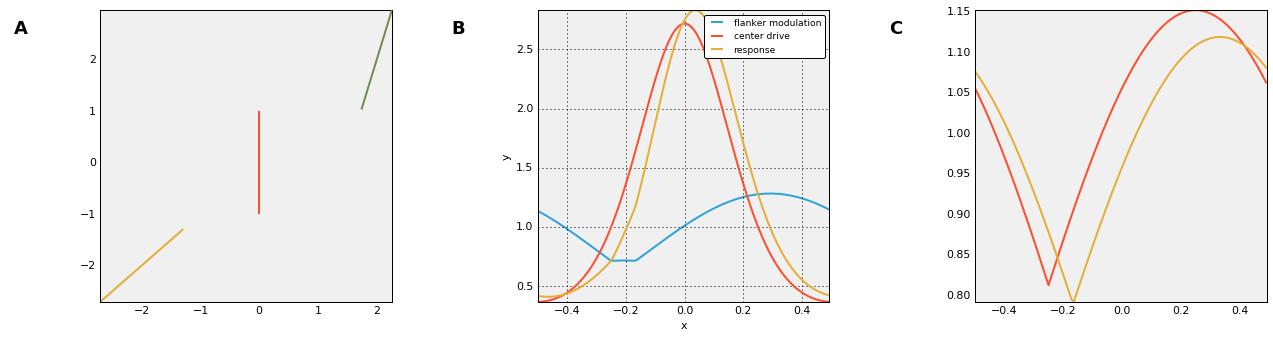

In [4]:
%%opts Curve {+axiswise} 
# above makes sure the normalization is done by axis, rather than across all of them

# set bar orientations
a1 = 0*pi/180 # bar 1 orientation
a2 = 45*pi/180 # bar 2 orientation
a3 = 15*pi/180 # bar 3 orientation
A  = pl.array([a1,a2,a3])

# set bar positions (x and y positions)
X = pl.array([[0,0],[-2,-2],[2,2]])

# Setup the scene
scene_3b = en.scene(N,A,X,[15,15],Kc,Ac,a,E0)

# plot
plotsceneandresponses(scene_3b,iLoc=0)

A center bar and n surround bars, with a center and surround orientation. The surround orientation rotates the entire surround.

:Layout
   .Overlay.I   :Overlay
      .Curve.I    :Curve   [x]   (y)
      .Curve.II   :Curve   [x]   (y)
      .Curve.III  :Curve   [x]   (y)
      .Curve.IV   :Curve   [x]   (y)
      .Curve.V    :Curve   [x]   (y)
      .Curve.VI   :Curve   [x]   (y)
      .Curve.VII  :Curve   [x]   (y)
      .Curve.VIII :Curve   [x]   (y)
   .Overlay.II  :Overlay
      .Curve.Flanker_modulation :Curve   [x]   (y)
      .Curve.Center_drive       :Curve   [x]   (y)
      .Curve.Response           :Curve   [x]   (y)
   .Overlay.III :Overlay
      .Curve.I   :Curve   [x]   (y)
      .Curve.II  :Curve   [x]   (y)
      .Curve.III :Curve   [x]   (y)
      .Curve.IV  :Curve   [x]   (y)
      .Curve.V   :Curve   [x]   (y)
      .Curve.VI  :Curve   [x]   (y)
      .Curve.VII :Curve   [x]   (y)
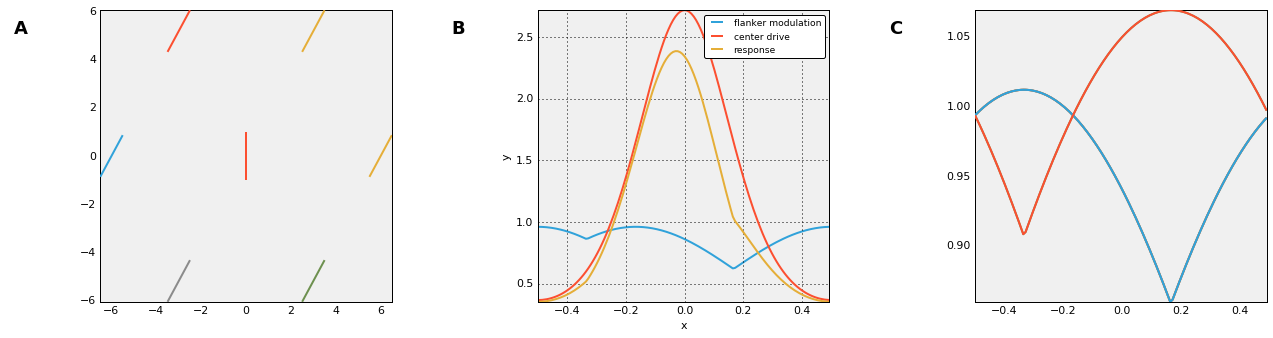

In [5]:
%%opts Curve {+axiswise} 
# above makes sure the normalization is done by axis, rather than across all of them
# set some scene parameters
ns = 6 # number of surround bars
R  = 6 # surround distance

# set bar orientations
c = 0*pi/180 # center bar orientation
s = 30*pi/180 # surround bars orientation
A  = pl.zeros(ns+1) # define all bars as having zero degree orientation
A[0] = c # sets first bar as center orientation
A[1:] = pl.ones(ns)*s # sets all other bars as surround orientation

# set bar positions (x and y positions)
X = pl.zeros((ns+1,2)) # set all bars positions to [0,0]
pos = pl.linspace(0,2*pi,ns+1)[:-1]+pi/2 # flanker angular positions (+ pi/2 to get the scene from figure 5F)
X[1:,0]= R*sin(pos) # sets x positions
X[1:,1]= R*cos(pos) # sets y positions
# (position of center is assumed to be [0,0])

# Setup the scene
scene_sur = en.scene(N,A,X,[15,15],Kc,Ac,a,E0)

# plot
plotsceneandresponses(scene_sur,iLoc=0)



Calculate the illusion for a given scene, for all flanker orientations

:Layout
   .Overlay.I :Overlay
      .Curve.I    :Curve   [x]   (y)
      .Curve.II   :Curve   [x]   (y)
      .Curve.III  :Curve   [x]   (y)
      .Curve.IV   :Curve   [x]   (y)
      .Curve.V    :Curve   [x]   (y)
      .Curve.VI   :Curve   [x]   (y)
      .Curve.VII  :Curve   [x]   (y)
      .Curve.VIII :Curve   [x]   (y)
      .Curve.IX   :Curve   [x]   (y)
      .Curve.X    :Curve   [x]   (y)
   .Curve.I   :Curve   [x]   (y)
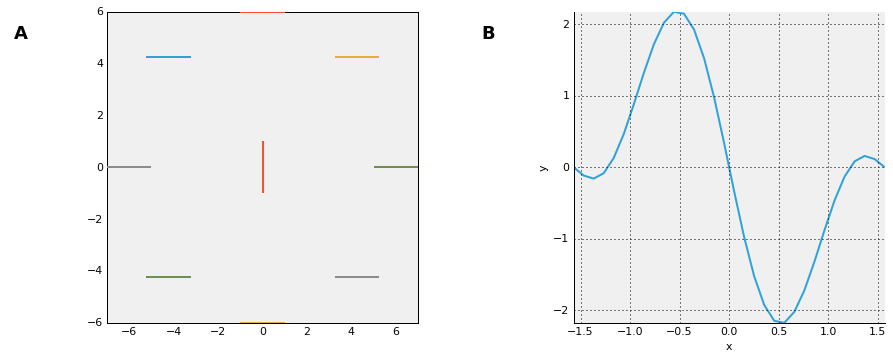

In [6]:
%%opts Curve {+axiswise} 
# above makes sure the normalization is done by axis, rather than across all of them

# set some scene parameters
ns = 8 # number of surround bars
R  = 6 # surround distance
nO = 32 # number of orientations to test
bias = pl.zeros(nO) # array to store decoding biases in

# set bar orientations
c = 0*pi/180 # center bar orientation
S = pl.linspace(-pi/2,pi/2,nO) # surround bars orientations
A  = pl.zeros(ns+1) # define all bars as having zero degree orientation
A[0] = c # sets first bar as center orientation

# set bar positions (x and y positions)
X = pl.zeros((ns+1,2)) # set all bars positions to [0,0]
pos = pl.linspace(0,2*pi,ns+1)[:-1]+pi/2 # flanker angular positions 
X[1:,0]= R*sin(pos) # sets x positions
X[1:,1]= R*cos(pos) # sets y positions

# set basic scene
scene = en.scene(N,A,X,[15,15],Kc,Ac,a,E0)

# loop over surround orientations
for i,s in enumerate(S):
    # reset positions
    pos = pl.linspace(0,2*pi,ns+1)[:-1]+pi/2+s # flanker angular positions , 
    #+s to make the entire surround rotate with surround orientation, remove that to keep bars in place (but still rotate)
    scene.X[1:,0]= R*sin(pos) # resets x positions flankers
    scene.X[1:,1]= R*cos(pos) # resets y positions flankers
    
    # set orientations 
    scene.O[1:] = s # sets all bars except center as surround orientation
    
    # simulate the neurons at the center location
    scene.simulate(0,torus='off')
    
    # get the encoded orientation of the center neuron
    bias[i] = scene.est[0]*180/pi

# plot the scene and biases
scene.plotscene()+hv.Curve(zip(S,bias))


Make a scene with a salient element

In [18]:
%%opts Curve {+axiswise} 
# above makes sure the normalization is done by axis, rather than across all of them
# set some scene parameters
ns = 6 # width of height of scene in bars

# set bar orientations
feat = 0*pi/180 # feature bar orientation
back = 30*pi/180 # background bars orientation
A  = pl.ones(ns*ns)*back # define all bars as having backgound degree orientation
A[range(ns),range(ns)]= feat
# set bar positions (x and y positions)
pos
X = pl.array([[x,y] for x in pl.arange(ns)*2 for y in pl.arange(ns)*2]) # set all bars positions

# Setup the scene
scene_sur = en.scene(N,A,X,[15,15],Kc,Ac,a,E0)

# plot
scene_sur.plotscene()


IndexError: too many indices for array